# Autonomous Vehicles Animal Detection

Run the following cell if you are working on colab

In [1]:
!git clone https://github.com/Giovannicus/AnimalRec.git
%cd /content/AnimalRec
%pwd

Cloning into 'AnimalRec'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 58 (delta 27), reused 35 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 715.84 KiB | 2.04 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/content/AnimalRec


'/content/AnimalRec'

In [2]:
import eda_batch
from logo import logo
import tarfile
import os
import numpy as np
from PIL import Image
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from tensorflow.keras.initializers import RandomNormal

import plotly.graph_objects as go
from sklearn.model_selection import StratifiedKFold

In [3]:
from tensorflow.keras.datasets.cifar10 import load_data

(X_train, Y_train), (x_test, y_test) = load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
logo()

# EDA

Try printing an image

In [ ]:
labels = ['airplane','automobile','bird','cat','deer','dog',\
          'frog','horse','ship','truck']

Image label frog


<ipython-input-12-ca55b4b16330>:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Image label {labels[int(y_train[0])]}")


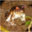

In [ ]:
print(f"Image label {labels[int(y_train[0])]}")
Image.fromarray(x_train[0])


# Preprocessing

Convert classes to binary animal or not

In [4]:
Y_train = ((Y_train >= 2) & (Y_train < 8)).astype(int)
y_test = ((y_test >= 2) & (y_test < 8)).astype(int)

### Pieplot target distribution

In [6]:
fig = go.Figure(data=[go.Pie(labels=["Animal", "Not animal"],
                             values=[np.mean(Y_train), 1 - np.mean(Y_train)],
                             hoverinfo="label+percent",  # Mostra etichetta, percentuale e valore
                             textinfo='percent',  # Mostra solo la percentuale sulle fette

                             pull=[0, 0.01],  # Evidenzia la seconda fetta
                             marker=dict(colors=['#FF0000', '#408040']),  # Colori personalizzati
                             textfont=dict(size=18)
                             )])


fig.update_layout(
    paper_bgcolor = "rgba(0,0,0,1)",
    plot_bgcolor = "rgba(0,0,0,1)",
    title={
        'text': "Target distribution",
        'font': {'color': 'white'}
    },
    font=dict(
        color='white',
        size=18
    ),
    legend=dict(
        font=dict(color='white')
    )
)

# Mostra il grafico
fig.show()

Distribution is fairly balanced

### Data augmentation

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale = 1/255.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
    )

val_datagen = ImageDataGenerator(
    rescale = 1/255.,
)

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train,test_size=.1,stratify=Y_train)

In [9]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=64)
val_generator = val_datagen.flow(x_val, y_val, batch_size=64)

# Model

## Transfer Learning

Use pre-trained vgg16 model freezing its conv layers

In [17]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in vgg16.layers:
    layer.trainable = False
vgg16 = Model(inputs=vgg16.inputs, outputs=vgg16.layers[-2].output)

add dense layers by yourself

In [22]:
w_init = RandomNormal(stddev=0.01)
x = vgg16.output
x = Flatten() (x)
#x = Dropout(0.2) (x)
x = Dense(512, activation='relu') (x)
x = Dense(128, activation='relu') (x)
x = Dense(32, activation='relu') (x)
x = Dropout(0.2) (x)
x = Dense(1, activation='sigmoid') (x)

In [23]:
clear_session()
model = Model(inputs=vgg16.input, outputs=x,name="vgg16_mod")
model.summary()

Model: "vgg16_mod"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,833,601 (60.40 MB)

 Trainable params: 1,118,913 (4.27 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Training

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True)


In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy', "precision"])
n_epochs = 15
hist = model.fit(train_generator,
              validation_data=val_generator,
              epochs=n_epochs,
              initial_epoch=0,
              verbose=1,
              callbacks =[early_stopping])

Epoch 1/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - accuracy: 0.8032 - loss: 0.4273 - precision: 0.8223 - val_accuracy: 0.8582 - val_loss: 0.3292 - val_precision: 0.8500
Epoch 2/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 52ms/step - accuracy: 0.8460 - loss: 0.3548 - precision: 0.8636 - val_accuracy: 0.8652 - val_loss: 0.3110 - val_precision: 0.8913
Epoch 3/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - accuracy: 0.8523 - loss: 0.3382 - precision: 0.8712 - val_accuracy: 0.8720 - val_loss: 0.3014 - val_precision: 0.8946
Epoch 4/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.8555 - loss: 0.3308 - precision: 0.8708 - val_accuracy: 0.8684 - val_loss: 0.3058 - val_precision: 0.9150
Epoch 5/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.8582 - loss: 0.3285 - precision: 0.8733 - val_accuracy: 0.8800 - val_loss: 0.2883 - val_precision: 0.8927


Save model and hist

In [27]:
model.save('vgg16_mod.h5')
import json


hist_dict = hist.history
with open('hist.json', 'w') as f:
    json.dump(hist_dict, f)


Load model and hist

In [28]:
import json

with open('hist.json', 'r') as f:
    hist = json.load(f)

from tensorflow.keras.models import load_model

model = load_model('vgg16_mod.h5')

# Results

Let's send output on brower avoiding visualization issues on VSC

In [ ]:
import plotly.io as pio

pio.renderers.default = 'browser'

fig.show()

In [53]:
plot_training_metrics(hist,3)

In [52]:
import plotly.graph_objects as go
import numpy as np
import math

def plot_training_metrics(hist, n_epochs):
    epochs = np.arange(1, n_epochs + 1)
    metrics = ["loss", "accuracy","precision", "val_loss", "val_accuracy", "val_precision"]

    fig = go.Figure()

    for metric in metrics:
        fig.add_trace(go.Scatter(x=epochs, y=hist[metric], mode='lines',
                                 name=metric.replace('_', ' ').title(),
                                 visible=(metric == "loss")))


    steps = []
    for i, metric in enumerate(metrics):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(metrics)},
                  {"title": f"{metric.replace('_', ' ').title()} over Epochs"}],
            label=metric.replace('_', ' ').title()
        )
        step["args"][0]["visible"][i] = True
        steps.append(step)

    sliders = [dict(
        active=0,
        currentvalue={"prefix": "Metric: "},
        pad={"t": 50},
        steps=steps
    )]

    fig.update_layout(
        sliders=sliders,
        title="Model Training Metrics",
        xaxis_title="Epochs",
        yaxis_title="Metric Value",
        height=600
    )

    fig.show()